# Solving MaxCut using the Quantum Approximate Optimization Algorithm (Qiskit)

This notebook contains an additional implementation of the Quantum Approximate Optimization Algorithm (QAOA). This is the second of two notebooks. The first notebook (implemented in Cirq) details the functions used in this notebook and used here as well as the algorithm.

In [1]:
from qiskit import execute, Aer, QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RZZGate
from qiskit.visualization import plot_histogram

import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize

In [2]:
backend_q = Aer.get_backend('qasm_simulator')

Edge class:

In [3]:
class Edge:
    def __init__(self, start_node, end_node, weight=1.00):
        self.start_node = start_node
        self.end_node = end_node
        self.weight = weight

A simple graph taken for example. Contains 5 nodes, 4 edges, all edges are unweighted.

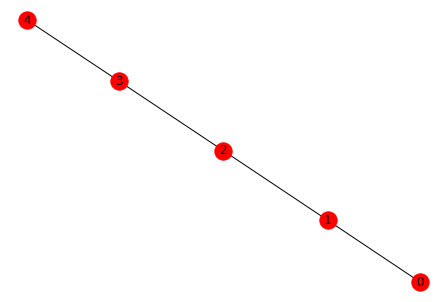

In [4]:
# set of edges, unweighted
set_edges = [Edge(0,1), Edge(1,2), Edge(2,3), Edge(3,4)]

# create the graph instance
G = nx.Graph()

# and add the edges to it
for edge in set_edges:
    G.add_edge(str(edge.start_node), str(edge.end_node), weight=edge.weight)

# print the graph
nx.draw(G, with_labels = True, node_color = 'r')

The cost unitary for the cost function hamiltonian:
<div align="center">$\large H_C = \sum_z (\sigma_i^z \otimes \sigma_j^z - I)$</div>

In [5]:
# the function to attach a cost unitary to each edge with iput gamma value
def cost_unitary(gamma, quc):
    for edge in set_edges:
        quc.append(RZZGate(gamma*edge.weight),[edge.start_node,edge.end_node])
    
    return quc

The mixer unitary for the mixer hamiltonian:  
<div align="center">$\large H_B = \sum_j \sigma_j^x$.</div>  

In [6]:
# the function to apply the mixer unitary
def mixer_unitary(beta, quc):
    for i in range(0,num):
        quc.rx(2*beta,i)
    return quc

The function `make_circuit` constructs the circuit based on input number of nodes `n`, $\normalsize\gamma$s (`gammas`), $\normalsize\beta$s (`betas`), and depth $\normalsize p$:

In [7]:
def make_circuit(n, gammas, betas, p):
    quc = QuantumCircuit(n)
    for i in range(0,n):
        quc.h(i)
    # print(cirquit)
    
    for i in range(0,p):
        cost_unitary(gammas[i], quc)
        mixer_unitary(betas[i], quc)
    
    # adding measurement gates
    quc.measure_all()

    return quc

The following function `get_results` returns the simulation results for the quantum circuit `quc` for `rep` number of shots.

In [8]:
def get_results(quc, rep=1000):
    results = execute(quc, backend = backend_q, shots=rep).result().get_counts()
    
    return results

(Qiskit's `get_counts` function returns a dictionary of the number of occurences of each bitstring that occured at least once. Hence we already have the format we had to process the results into, in the Cirq implementation)  

`get_cost` is an all-in-one function for building circuits, running them and calculating the average cost over all the simulation results.

In [9]:
def get_cost(params):
    gammas = []
    betas = []
    for i in range(0, len(params), 2):
        gammas.append(params[i])
    for i in range(1, len(params), 2):
        betas.append(params[i])
    
    qaoa = make_circuit(num, gammas, betas, p)
    results = get_results(qaoa, reps)
    
    # we calculate the cost
    cost = 0.0
    for k in results:
        for e in set_edges:
            cost += results[k]*e.weight*0.5*((1-2*int(k[e.start_node]))
                                  *(1-2*int(k[e.end_node]))-1)
    
    cost = float(cost)/reps
    
    return cost

Initializing random parameters for beta and gamma.

In [10]:
num = G.number_of_nodes()
p = 2
reps = 1000
init_params = [float(random.randint(0,314))/float(100) for i in range(0,2*p)] # [gamma, beta]
init_params

[3.11, 1.46, 0.32, 1.62]

Optimizing the `get_cost` function using `scipy.minimize`, and collecting the optimal parameters.

In [11]:
out = minimize(get_cost, x0 = init_params, method = "COBYLA", options = {'maxiter':100})
optimal_params = out['x']

# optimal gammas and optimal betas
opti_gammas = []
opti_betas = []

for i in range(0, len(optimal_params), 2):
    opti_gammas.append(optimal_params[i])
for i in range(1, len(optimal_params), 2):
    opti_betas.append(optimal_params[i])

print(optimal_params)
print(opti_gammas)
print(opti_betas)

[4.37060126 1.34589005 1.21979377 0.45241033]
[4.37060125639347, 1.2197937681120568]
[1.3458900471353656, 0.45241032681322507]


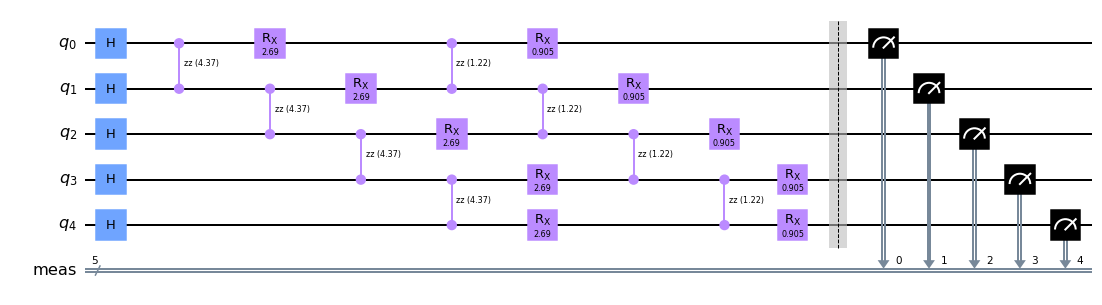

In [12]:
qaoa_opti = make_circuit(num, opti_gammas, opti_betas, p)
qaoa_opti.draw('mpl')

Simulate and collect the reuslts of running the above optimal circuit.

In [13]:
reps = 1000
results = get_results(qaoa_opti, rep = reps)

# note the number denoted by the binary representation and its frequency
nums = []
freq = []

for k in results:
    nums.append(int(k,2))
    freq.append(results[k])

# divide the frequency by the total number of samples
freq = [f/reps for f in freq]

print(nums)
print(freq)

[0, 1, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 29, 30, 31, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
[0.003, 0.003, 0.007, 0.011, 0.056, 0.033, 0.221, 0.054, 0.007, 0.004, 0.055, 0.025, 0.004, 0.006, 0.003, 0.009, 0.001, 0.025, 0.047, 0.005, 0.007, 0.065, 0.217, 0.059, 0.001, 0.05, 0.011, 0.011]


Function `plot_results` to plot the results.

In [14]:
# plot
def plot_results(nums, freq):
    x = range(0, 2**num) # all possible numbers
    y = []
    for i in range(0, len(x)):
        if (i in nums):
            y.append(freq[nums.index(i)])
        else:
            y.append(0)

    plt.figure(figsize=(10,8))
    plt.bar(x, y)
    plt.show()
    return x,y

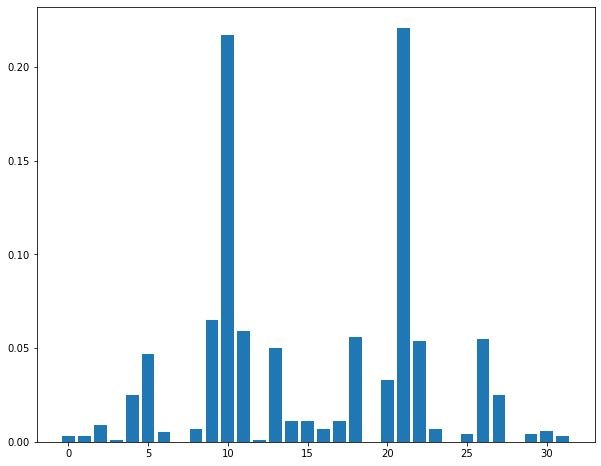

In [15]:
x,y = plot_results(nums, freq)

In [16]:
print("Binary Expansion of 10: {}".format(np.binary_repr(10,num)))
print("Binary Expansion of 21: {}".format(np.binary_repr(21,num)))

Binary Expansion of 10: 01010
Binary Expansion of 21: 10101


They are the negation of each other, meaning that the following partition-  
Nodes {$0,2,4$} in one group and  
Nodes {$1,3$} in the other give the biggest cut, i.e. maximum number of edges crossing across the two sets, i.e. = 4.

The function `get_weight` calculates the weight corresponding to the solutions indicated by our algorithm:

In [17]:
def get_weight(solution):
    total_weight = 0.0
    # convert the number to binary
    sol = [n for n in list(np.binary_repr(solution, num))]
    grp_0 = []
    grp_1 = []
    for i in range(len(sol)):
        if sol[i] == '0':
            grp_0.append(i)
        else:
            grp_1.append(i)
    
    for i in grp_0:
        for j in grp_1:
            if G.has_edge(str(i),str(j)):
                total_weight += G.get_edge_data(str(i),str(j))['weight']
    
    return total_weight

In [18]:
print("Weight of solution 10 is: {}".format(get_weight(10)))
print("Weight of solution 21 is: {}".format(get_weight(21)))

Weight of solution 10 is: 4.0
Weight of solution 21 is: 4.0


In [19]:
# driver function to run the entire algorithm with inputs G as input
# the argument 'count' is to return that many most probable solutions

def driver(G, count=5):
    init_params = [float(random.randint(0,314))/float(100) for i in range(0,2*p)]
    out = minimize(get_cost, x0 = init_params,
                   method = "COBYLA", options = {'maxiter':100})
    optimal_params = out['x']
    
    # optimal gammas and optimal betas
    opti_gammas = []
    opti_betas = []

    for i in range(0, len(optimal_params), 2):
        opti_gammas.append(optimal_params[i])
    for i in range(1, len(optimal_params), 2):
        opti_betas.append(optimal_params[i])
    
    qaoa_opti = make_circuit(num, opti_gammas, opti_betas, p)
    
    results = get_results(qaoa_opti, rep = reps)

    nums = []
    freq = []
    for k in results:
        nums.append(int(k,2))
        freq.append(results[k])

    # divide the frequency by the total number of samples
    freq = [f/reps for f in freq]
    x,y = plot_results(nums, freq)
    
    top = np.argsort(y,)[-count:]
    top = list(top[::-1])
    
    for i in range(count):
        print("The binary represention of",top[i],"is:",
              np.binary_repr(top[i], num),
              "| weight =",get_weight(top[i]))
    return qaoa_opti, top

Let's try a longer straight-line graph, still unweighted, with 9 nodes and 8 edges. We expect to see the same type of partition, i.e. 010101010 or 101010101, meaning the numbers 170 or 341 respectively.

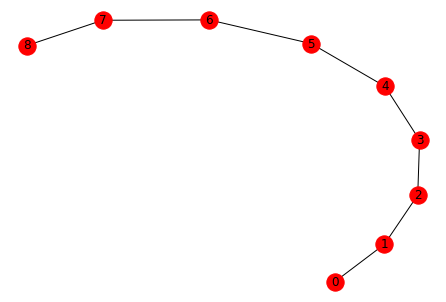

In [20]:
set_edges = [Edge(0,1), Edge(1,2), Edge(2,3), Edge(3,4),
             Edge(4,5), Edge(5,6), Edge(6,7), Edge(7,8)
            ]

G = nx.Graph()
for edge in set_edges:
    G.add_edge(str(edge.start_node), str(edge.end_node), weight=edge.weight)
    
nx.draw(G, with_labels = True, node_color='r')

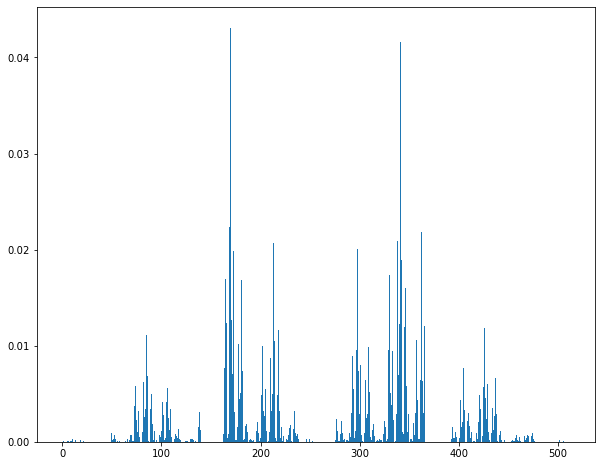

The binary represention of 170 is: 010101010 | weight = 8.0
The binary represention of 341 is: 101010101 | weight = 8.0
The binary represention of 169 is: 010101001 | weight = 7.0
The binary represention of 362 is: 101101010 | weight = 7.0
The binary represention of 338 is: 101010010 | weight = 7.0


In [21]:
num = G.number_of_nodes()
p = 1
reps = 10000
qaoa, top = driver(G)

Next we try a weighted graph. Notice we have already incorporated edge's weight term into the gamma parameter of the RZZ gate in the cost unitary, and in the cost function `get_cost`. And our class `Edge`'s  initialization function takes in an input for weight. Let's try a simple weighted graph, 4 nodes, 4 edges, with  
* weight 5.0 on the edge from 0 to 1,
* weight 1.0 on the edge from 1 to 2,
* weight 5.0 on the edge from 2 to 3,
* weight 5.0 on the edge from 3 to 0.  

We expect the partitions to be {$0, 2$} and {$1, 3$}, i.e. numbers 5 or 10

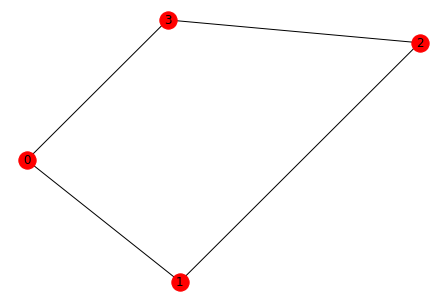

In [22]:
set_edges = [Edge(0,1,5.0), Edge(1,2,1.0), Edge(2,3,5.0), Edge(3,0,5.0)]
G = nx.Graph()
for edge in set_edges:
    G.add_edge(str(edge.start_node), str(edge.end_node), weight = edge.weight)

nx.draw(G, with_labels = True, node_color = 'r')

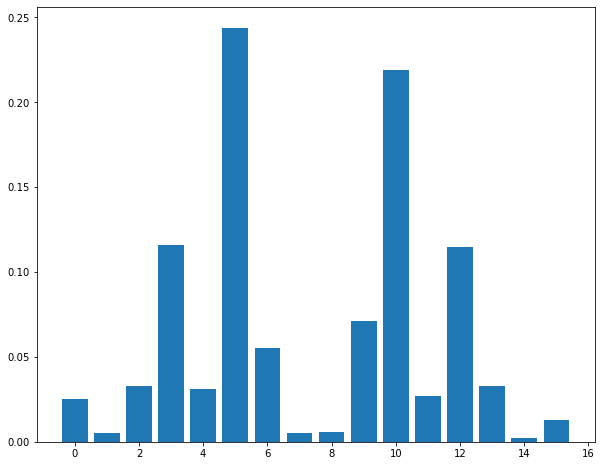

The binary represention of 5 is: 0101 | weight = 16.0
The binary represention of 10 is: 1010 | weight = 16.0
The binary represention of 3 is: 0011 | weight = 6.0
The binary represention of 12 is: 1100 | weight = 6.0
The binary represention of 9 is: 1001 | weight = 10.0


In [23]:
num = G.number_of_nodes()
p = 1
reps = 1000
qaoa = driver(G)

Let's run the algorithm on a scaled up, weighted graph example that can be found [here](http://eaton.math.rpi.edu/faculty/Mitchell/courses/matp6620/notesMATP6620/lecture11/11B_maxcut.pdf) (image below).  
The pdf mentions 41 as one of the high weights.

WEIGHTED MAXCUT EXAMPLE


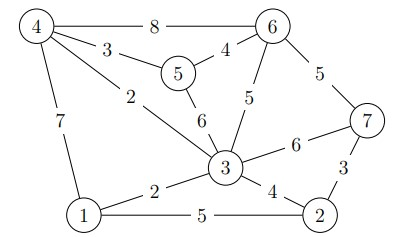

In [1]:
from IPython.display import Image
print("WEIGHTED MAXCUT EXAMPLE")
Image("w_maxcut_example.jpg", width=300, height=300)

We calculated in the first notebook that the optimal solution to this graph is a weight of 47, which occurs on the partitions defined by the numbers 45 (0101101) and 82 (1010010). These are the weights we expect to see among the most probable states returned by the algorithm.

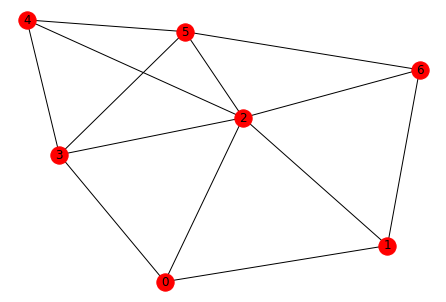

In [24]:
set_edges = [Edge(0,1,5.0), Edge(0,2,2.0), Edge(0,3,7.0), 
             Edge(1,2,4.0), Edge(1,6,3.0),
             Edge(2,3,2.0), Edge(2,4,6.0), Edge(2,5,5.0), Edge(2,6,6.0),
             Edge(3,4,3.0), Edge(3,5,8.0),
             Edge(4,5,4.0),
             Edge(5,6,5.0)
            ]

G = nx.Graph()
for edge in set_edges:
    G.add_edge(str(edge.start_node), str(edge.end_node), weight = edge.weight)
    
nx.draw(G, with_labels=True, node_color='r')

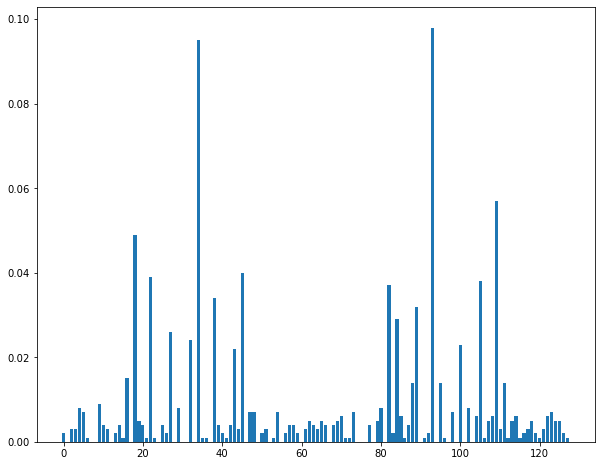

The binary represention of 93 is: 1011101 | weight = 34.0
The binary represention of 34 is: 0100010 | weight = 34.0
The binary represention of 109 is: 1101101 | weight = 37.0
The binary represention of 18 is: 0010010 | weight = 37.0
The binary represention of 45 is: 0101101 | weight = 47.0
The binary represention of 22 is: 0010110 | weight = 30.0
The binary represention of 105 is: 1101001 | weight = 30.0
The binary represention of 82 is: 1010010 | weight = 47.0
The binary represention of 38 is: 0100110 | weight = 39.0
The binary represention of 89 is: 1011001 | weight = 39.0


In [25]:
num = G.number_of_nodes()
p = 2
reps = 1000
qaoa, top = driver(G, count=10)

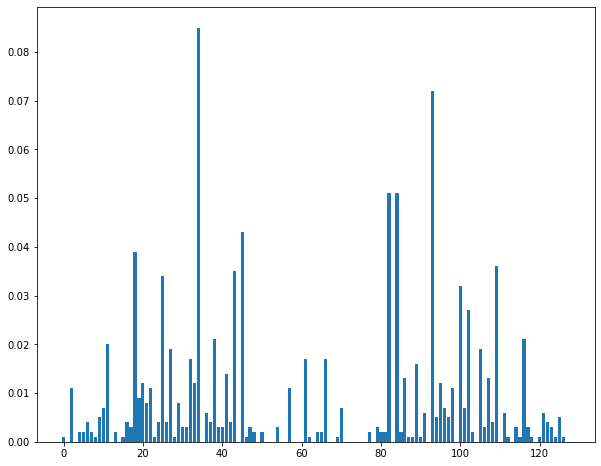

The binary represention of 34 is: 0100010 | weight = 34.0
The binary represention of 93 is: 1011101 | weight = 34.0
The binary represention of 82 is: 1010010 | weight = 47.0
The binary represention of 84 is: 1010100 | weight = 36.0
The binary represention of 45 is: 0101101 | weight = 47.0
The binary represention of 18 is: 0010010 | weight = 37.0
The binary represention of 109 is: 1101101 | weight = 37.0
The binary represention of 43 is: 0101011 | weight = 36.0
The binary represention of 25 is: 0011001 | weight = 43.0
The binary represention of 100 is: 1100100 | weight = 29.0


In [26]:
num = G.number_of_nodes()
p = 2
reps = 1000
qaoa, top = driver(G, count=10)